# Deepwalk

In [ ]:
import os
import sys
import random
from io import open
from collections import Counter
from concurrent.futures import ProcessPoolExecutor
from gensim.models import Word2Vec
from six import text_type as unicode
from six import iteritems
from six.moves import range
import psutil
from multiprocessing import cpu_count
from os import path
from time import time
from glob import glob
from six.moves import range, zip, zip_longest
from six import iterkeys
from collections import defaultdict, Iterable
import random
from random import shuffle
from itertools import product,permutations
from scipy.io import loadmat
from scipy.sparse import issparse
from io import open
from os import path
from time import time
from multiprocessing import cpu_count
import random
from concurrent.futures import ProcessPoolExecutor
from collections import Counter
from six.moves import zip
os.system('pip install gensim')
os.system('pip install psutil')
# 服务器执行 单机跑不动



p = psutil.Process(os.getpid())
try:
    p.set_cpu_affinity(list(range(cpu_count())))
except AttributeError:
    try:
        p.cpu_affinity(list(range(cpu_count())))
    except AttributeError:
        pass

LOGFORMAT = "%(asctime).19s %(levelname)s %(filename)s: %(lineno)s %(message)s"


def debug(type_, value, tb):
    if hasattr(sys, 'ps1') or not sys.stderr.isatty():
        sys.__excepthook__(type_, value, tb)
    else:
        import traceback
        import pdb
        traceback.print_exception(type_, value, tb)
        print(u"\n")
        pdb.pm()

# __author__ = "Bryan Perozzi"
__email__ = "bperozzi@cs.stonybrook.edu"

LOGFORMAT = "%(asctime).19s %(levelname)s %(filename)s: %(lineno)s %(message)s"

class Graph(defaultdict):
    """Efficient basic implementation of nx `Graph' â€“ Undirected graphs with self loops"""  
    def __init__(self):
        super(Graph, self).__init__(list)

    def nodes(self):
        return self.keys()

    def adjacency_iter(self):
        return self.iteritems()

    def subgraph(self, nodes={}):
        subgraph = Graph()

        for n in nodes:
            if n in self:
                subgraph[n] = [x for x in self[n] if x in nodes]

        return subgraph

    def make_undirected(self):

        t0 = time()

        for v in self.keys():
            for other in self[v]:
                if v != other:
                    self[other].append(v)

        t1 = time()

        self.make_consistent()
        return self

    def make_consistent(self):
        t0 = time()
        for k in iterkeys(self):
            self[k] = list(sorted(set(self[k])))

        t1 = time()

        self.remove_self_loops()

        return self

    def remove_self_loops(self):

        removed = 0
        t0 = time()

        for x in self:
            if x in self[x]: 
                self[x].remove(x)
                removed += 1

        t1 = time()

        return self

    def check_self_loops(self):
        for x in self:
            for y in self[x]:
                if x == y:
                return True

        return False

    def has_edge(self, v1, v2):
        if v2 in self[v1] or v1 in self[v2]:
            return True
        return False

    def degree(self, nodes=None):
        if isinstance(nodes, Iterable):
            return {v:len(self[v]) for v in nodes}
        else:
            return len(self[nodes])

    def order(self):
    "Returns the number of nodes in the graph"
        return len(self)    

    def number_of_edges(self):
    "Returns the number of nodes in the graph"
        return sum([self.degree(x) for x in self.keys()])/2

    def number_of_nodes(self):
    "Returns the number of nodes in the graph"
        return order()

    def random_walk(self, path_length, alpha=0, rand=random.Random(), start=None):
        """ Returns a truncated random walk.
            path_length: Length of the random walk.
            alpha: probability of restarts.
            start: the start node of the random walk.
        """
        G = self
        if start:
            path = [start]
        else:
        # Sampling is uniform w.r.t V, and not w.r.t E
            path = [rand.choice(list(G.keys()))]

        while len(path) < path_length:
        cur = path[-1]
        if len(G[cur]) > 0:
            if rand.random() >= alpha:
                path.append(rand.choice(G[cur]))
            else:
                path.append(path[0])
        else:
            break
        return [str(node) for node in path]

# TODO add build_walks in here

def build_deepwalk_corpus(G, num_paths, path_length, alpha=0,
                      rand=random.Random(0)):
    walks = []

    nodes = list(G.nodes())

    for cnt in range(num_paths):
        rand.shuffle(nodes)
        for node in nodes:
            walks.append(G.random_walk(path_length, rand=rand, alpha=alpha, start=node))

    return walks

def build_deepwalk_corpus_iter(G, num_paths, path_length, alpha=0,
                      rand=random.Random(0)):
    walks = []

    nodes = list(G.nodes())

    for cnt in range(num_paths):
        rand.shuffle(nodes)
        for node in nodes:
            yield G.random_walk(path_length, rand=rand, alpha=alpha, start=node)


def clique(size):
    return from_adjlist(permutations(range(1,size+1)))


# http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks-in-python
def grouper(n, iterable, padvalue=None):
    "grouper(3, 'abcdefg', 'x') --> ('a','b','c'), ('d','e','f'), ('g','x','x')"
    return zip_longest(*[iter(iterable)]*n, fillvalue=padvalue)

def parse_adjacencylist(f):
    adjlist = []
    for l in f:
        if l and l[0] != "#":
            introw = [int(x) for x in l.strip().split()]
            row = [introw[0]]
            row.extend(set(sorted(introw[1:])))
            adjlist.extend([row])

    return adjlist

def parse_adjacencylist_unchecked(f):
    adjlist = []
    for l in f:
        if l and l[0] != "#":
            adjlist.extend([[int(x) for x in l.strip().split()]])

    return adjlist

def load_adjacencylist(file_, undirected=False, chunksize=10000, unchecked=True):

    if unchecked:
        parse_func = parse_adjacencylist_unchecked
        convert_func = from_adjlist_unchecked
    else:
        parse_func = parse_adjacencylist
        convert_func = from_adjlist

    adjlist = []

    t0 = time()

    total = 0 
    with open(file_) as f:
        for idx, adj_chunk in enumerate(map(parse_func, grouper(int(chunksize), f))):
            adjlist.extend(adj_chunk)
            total += len(adj_chunk)
    t1 = time()
    t0 = time()
    G = convert_func(adjlist)
    t1 = time()


    if undirected:
        t0 = time()
        G = G.make_undirected()
        t1 = time()

    return G 


def load_edgelist(file_, undirected=True):
    G = Graph()
    with open(file_) as f:
        for l in f:
            x, y = l.strip().split()[:2]
            x = int(x)
            y = int(y)
            G[x].append(y)
            if undirected:
                G[y].append(x)

    G.make_consistent()
    return G


def load_matfile(file_, variable_name="network", undirected=True):
    mat_varables = loadmat(file_)
    mat_matrix = mat_varables[variable_name]

    return from_numpy(mat_matrix, undirected)


def from_networkx(G_input, undirected=True):
    G = Graph()

    for idx, x in enumerate(G_input.nodes_iter()):
        for y in iterkeys(G_input[x]):
            G[x].append(y)

    if undirected:
        G.make_undirected()

    return G


def from_numpy(x, undirected=True):
    G = Graph()

    if issparse(x):
        cx = x.tocoo()
        for i,j,v in zip(cx.row, cx.col, cx.data):
            G[i].append(j)
    else:
        raise Exception("Dense matrices not yet supported.")

    if undirected:
        G.make_undirected()

    G.make_consistent()
    return G


def from_adjlist(adjlist):
    G = Graph()
    
    for row in adjlist:
        node = row[0]
        neighbors = row[1:]
        G[node] = list(sorted(set(neighbors)))

    return G


def from_adjlist_unchecked(adjlist):
    G = Graph()
    
    for row in adjlist:
        node = row[0]
        neighbors = row[1:]
        G[node] = neighbors

    return G

from collections import Counter, Mapping
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count
from six import string_types

from gensim.models import Word2Vec
from gensim.models.word2vec import Vocab


class Skipgram(Word2Vec):
    """A subclass to allow more customization of the Word2Vec internals."""

    def __init__(self, vocabulary_counts=None, **kwargs):

        self.vocabulary_counts = None

        kwargs["min_count"] = kwargs.get("min_count", 0)
        kwargs["workers"] = kwargs.get("workers", cpu_count())
        kwargs["size"] = kwargs.get("size", 128)
        kwargs["sentences"] = kwargs.get("sentences", None)
        kwargs["window"] = kwargs.get("window", 10)
        kwargs["sg"] = 1
        kwargs["hs"] = 1

        if vocabulary_counts != None:
            self.vocabulary_counts = vocabulary_counts

        super(Skipgram, self).__init__(**kwargs)


__current_graph = None

# speed up the string encoding
__vertex2str = None

def count_words(file):
    """ Counts the word frequences in a list of sentences.
  Note:
    This is a helper function for parallel execution of `Vocabulary.from_text`
    method.
  """
    c = Counter()
    with open(file, 'r') as f:
        for l in f:
            words = l.strip().split()
            c.update(words)
    return c


def count_textfiles(files, workers=1):
    c = Counter()
    with ProcessPoolExecutor(max_workers=workers) as executor:
        for c_ in executor.map(count_words, files):
            c.update(c_)
    return c


def count_lines(f):
    if path.isfile(f):
        num_lines = sum(1 for line in open(f))
        return num_lines
    else:
        return 0

def _write_walks_to_disk(args):
    num_paths, path_length, alpha, rand, f = args
    G = __current_graph
    t_0 = time()
    with open(f, 'w') as fout:
        for walk in graph.build_deepwalk_corpus_iter(G=G, num_paths=num_paths, path_length=path_length,
                                             alpha=alpha, rand=rand):
            fout.write(u"{}\n".format(u" ".join(v for v in walk)))
    return f

def write_walks_to_disk(G, filebase, num_paths, path_length, alpha=0, rand=random.Random(0), num_workers=cpu_count(),
                        always_rebuild=True):
    global __current_graph
    __current_graph = G
    files_list = ["{}.{}".format(filebase, str(x)) for x in list(range(num_paths))]
    expected_size = len(G)
    args_list = []
    files = []

    if num_paths <= num_workers:
        paths_per_worker = [1 for x in range(num_paths)]
    else:
        paths_per_worker = [len(list(filter(lambda z: z!= None, [y for y in x])))
                        for x in graph.grouper(int(num_paths / num_workers)+1, range(1, num_paths+1))]

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        for size, file_, ppw in zip(executor.map(count_lines, files_list), files_list, paths_per_worker):
            if always_rebuild or size != (ppw*expected_size):
                args_list.append((ppw, path_length, alpha, random.Random(rand.randint(0, 2**31)), file_))
            else:
                files.append(file_)

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        for file_ in executor.map(_write_walks_to_disk, args_list):
            files.append(file_)

    return files

class WalksCorpus(object):
    def __init__(self, file_list):
        self.file_list = file_list
    def __iter__(self):
        for file in self.file_list:
            with open(file, 'r') as f:
                for line in f:
                    yield line.split()

def combine_files_iter(file_list):
    for file in file_list:
        with open(file, 'r') as f:
            for line in f:
                yield line.split()





def process(inputfile, output,representation_size = 64,window_size = 5 ,walk_length = 40,number_walks = 80,  undirected =True):
    G = load_edgelist(inputfile, undirected=undirected)
    print("Number of nodes: {}".format(len(G.nodes())))

    num_walks = len(G.nodes()) * number_walks

    print("Number of walks: {}".format(num_walks))

    data_size = num_walks * walk_length

    print("Data size (walks*length): {}".format(data_size))

    print("Walking...")
    walks = build_deepwalk_corpus(G, num_paths= number_walks,
                                      path_length=walk_length, alpha=0, rand=random.Random(66))
    print("Training...")
    model = Word2Vec(walks, size=representation_size, window= window_size, min_count=0, sg=1, hs=1, workers= 10)

    model.wv.save_word2vec_format(output)

def rundeepwalk():
    cacheRoot = "../cache/"
    inputfile = cacheRoot +  "merchant_weighted_edglist_DeepWalk.txt"
    output = cacheRoot + "merchant_weighted_edglist_DeepWalk.embeddings" 
    # files = os.listdir(inputP)
    process(inputfile, output)
    

rundeepwalk()
# deepwalk --format edgelist  --input /usr/local/glsample/dep_wk_data/geo_code_edglist.txt \
# --max-memory-data-size 1319014400 --number-walks 80 --representation-size 36 --walk-length 40 --window-size 10 \
# --workers 8 --output /usr/local/glsample/geo_code_edglist.embeddings

# Node2Vec

In [ ]:
# os.system('pip install node2vec')

In [1]:
import networkx as nx
from node2vec import Node2Vec
import sys

def emb_graph_2vec(inputpath,dim):
    print("input name will be ",inputpath)
    emb_name = inputpath.replace("weighted_edglist_filytypeTxt.edgelist","")
    print("emb_name will be ",emb_name)

    savename =inputpath.replace("weighted_edglist_filytypeTxt.edgelist",".emb")
    print("emb outfile name will be ",savename)
    if os.path.exists(savename):
        print("file alread exists in cache, please rename")
        sys.exit(1)

    graph = nx.read_edgelist(inputpath,create_using=nx.DiGraph())
    # Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
    node2vec = Node2Vec(graph, dimensions=dim, walk_length=30, num_walks=200, workers=10) 
    # Embed nodes
    print("training .... ")
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    print("training finished saving result... ")

    print("saving %s file to disk "%savename)
    # Save embeddings for later use
    model.wv.save_word2vec_format(savename)
    print("done")
    # Save model for later use



D:\Programfiles2\anaconda\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import os
cacheRoot = "../cache/"
inputpath = cacheRoot + "mac1_weighted_edglist_filytypeTxt.edgelist"
try:
    emb_graph_2vec(inputpath,36)
except Exception as e:
    print(e)
print("1")

input name will be  ./compFeatures/sourceEmb/mac1_weighted_edglist_filytypeTxt.edgelist
emb_name will be  ./compFeatures/sourceEmb/mac1_
emb outfile name will be  ./compFeatures/feature/mac1_.emb


Computing transition probabilities: 100%|█| 132349/132349 [00:02<00:00, 48075.19it/s]


training .... 
training finished saving result... 
saving ./compFeatures/feature/mac1_.emb file to disk 
done
1


In [ ]:
inputpath =  cacheRoot +  "merchant_weighted_edglist_filytypeTxt.edgelist"
try:
    emb_graph_2vec(inputpath,64)
except Exception as e:
    print(e)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from sklearn.svm import SVC
warnings.simplefilter(action='ignore', category=FutureWarning)
dataroot = "../data/"
cacheRoot = "../cache/"
import pandas as pd
import numpy as np

In [2]:
def get_embeding(fname, embname):
    f = open(fname)
    embeding_lines = f.readlines()
    f.close()
    mapfunc = lambda x: list( map( float, x ) )
    embeding_lines = [li.replace("\n","").split(" ") for li in embeding_lines[1:]]
    embeding_lines = [ [ int(line[0]) ] +  mapfunc( line[1:]  )   for line in   embeding_lines ]
    cols = ["UID"] + [ embname  + str(i) for i in range( len(embeding_lines[0]) -1 )]
    embeding_df = pd.DataFrame(embeding_lines, columns=cols )
    del embeding_lines
    return embeding_df


In [34]:
mac1_emb = get_embeding(cacheRoot + "mac1_edglist_emb_dim36.emb", "mac1_emb_")
# merchant_dbk = get_embeding(cacheRoot + "merchant_weighted_edglist_DeepWalk.embeddings", "merchant_deepwalk_")

In [35]:
from sklearn.decomposition import PCA
dim = 2
pca = PCA(n_components=dim)
pca_res = pca.fit_transform(mac1_emb.drop("UID", axis = 1)  )
me_pca = pd.DataFrame(pca_res, columns=["pca_mac1_%d" % i for i in range(dim)])
me_pca["UID"] = mac1_emb.UID.values

In [31]:
data =  pd.read_csv(cacheRoot + "grouping_features.csv")

In [27]:
data = data[[ 'UID','Tag' ]]

In [33]:
len(data)

62767

In [28]:
data = data.merge(pacdatd,on=['UID'])

In [29]:
data.Tag.mean()

0.2797967217489936

In [30]:
len(data)

44963

In [87]:
# me_pca.head(100)
# pacdat = me_pca.query("pca_mac1_1 <= 2  ")
pacdat = me_pca[ me_pca.UID.map(lambda x: x<= 131587) ] 

# pacdatd = pacdat.query("pca_mac1_0 < 5  ").query("pca_mac1_0 >3.25  ")
pacdatd = pacdat.query("pca_mac1_0 < 3.25  ").query("pca_mac1_0 >  3")
pacdatdd = pacdatd.query("pca_mac1_1 < -0.023  ")

In [91]:
dd = data.merge(pacdatd,on=['UID'])

In [92]:
dd.Tag.mean()

0.35

In [129]:
from sklearn.cluster import KMeans

X = dd[['pca_mac1_0', 'pca_mac1_1']]
kmeans = KMeans(n_clusters=18)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

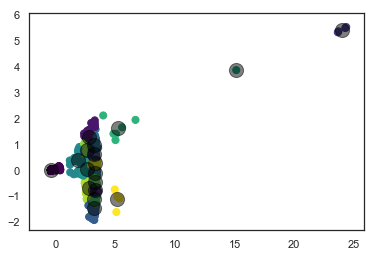

In [136]:
X = pacdat[['pca_mac1_0', 'pca_mac1_1']]
kmeans = KMeans(n_clusters=18)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X['pca_mac1_0'], X['pca_mac1_1'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

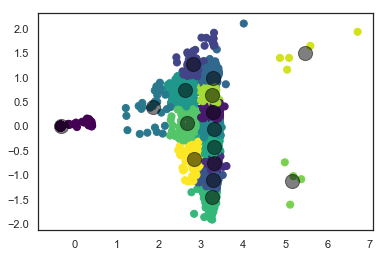

In [139]:
X = pacdat.query(" pca_mac1_0<10 ")[['pca_mac1_0', 'pca_mac1_1']]
kmeans = KMeans(n_clusters=16)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X['pca_mac1_0'], X['pca_mac1_1'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

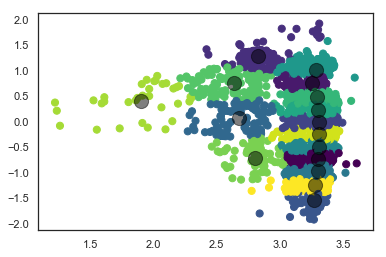

In [142]:
ddp = pacdat.query(" pca_mac1_0 > 1 ").query(" pca_mac1_0<4 ")
X = ddp[['pca_mac1_0', 'pca_mac1_1']]
kmeans = KMeans(n_clusters=16)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X['pca_mac1_0'], X['pca_mac1_1'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [143]:
ddp['ym'] = y_kmeans

In [144]:
ddp = pd.merge(data,ddp)

In [145]:
ddp.groupby('ym')['Tag'].agg({'TagMean':"mean"}).reset_index()

,ym,TagMean
0,0,0.398630
1,1,0.385057
2,2,0.358782
3,3,0.451058
4,4,0.396175
5,5,0.386667
6,6,0.404412
7,7,0.521845
8,8,0.401163
9,9,0.422753


In [ ]:
len(ddp[ddp['ym'] == 7])

In [169]:
ddp = pd.merge(data,pacdat)
# ddp = ddp.query(" pca_mac1_0 > 1 ").query(" pca_mac1_0<4 ")
X = ddp[['pca_mac1_0', 'pca_mac1_1']]
kmeans = KMeans(n_clusters=18)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
ddp['ym'] = y_kmeans
tgm = ddp.groupby('ym')['Tag'].agg({'TagMean':"mean"}).reset_index()
ddp = ddp.merge(tgm,on =['ym']  )
# plt.scatter(X['pca_mac1_0'], X['pca_mac1_1'], c=y_kmeans, s=50, cmap='viridis')

# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

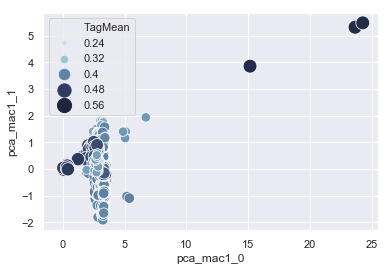

In [170]:
import seaborn as sns
sns.set()

# Load the example iris dataset
planets = sns.load_dataset("planets")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x="pca_mac1_0", y="pca_mac1_1",
                     hue="TagMean", size="TagMean",
                     palette=cmap, sizes=(10, 200),
                     data=ddp)


# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

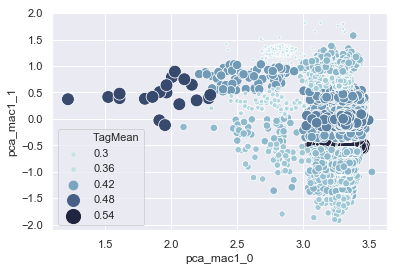

In [168]:
import seaborn as sns
sns.set()

# Load the example iris dataset
planets = sns.load_dataset("planets")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x="pca_mac1_0", y="pca_mac1_1",
                     hue="TagMean", size="TagMean",
                     palette=cmap, sizes=(10, 200),
                     data=ddp)


# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

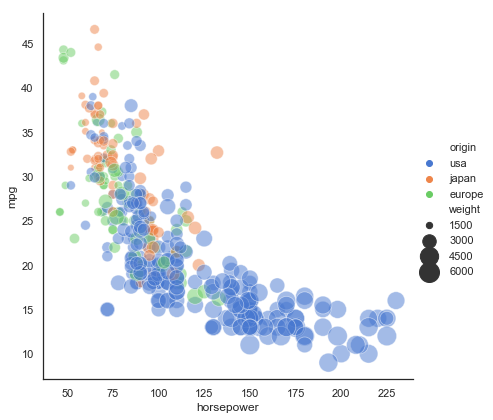

In [164]:
# import seaborn as sns
# sns.set(style="white")

# # Load the example mpg dataset

# # Plot miles per gallon against horsepower with other semantics
# sns.relplot(x="pca_mac1_0", y="pca_mac1_1", hue="Tag",
#             sizes=(40, 400), alpha=.5, palette="muted",
#             height=6, data=ddp)
import seaborn as sns
sns.set()

# Load the example iris dataset
planets = sns.load_dataset("planets")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

ax = sns.scatterplot(x="distance", y="orbital_period",
                     hue="year", size="mass",
                     palette=cmap, sizes=(10, 200),
                     data=planets)

In [151]:
ddp['ym'] = y_kmeans
ddp = pd.merge(data,ddp)
ddp.groupby('ym')['Tag'].agg({'TagMean':"mean"}).reset_index()

,ym,TagMean
0,0,0.485788
1,1,0.358059
2,2,0.452722
3,3,0.408356
4,4,0.395923
5,5,0.380597
6,6,0.440051
7,7,0.389610
8,8,0.392157
9,9,0.396226


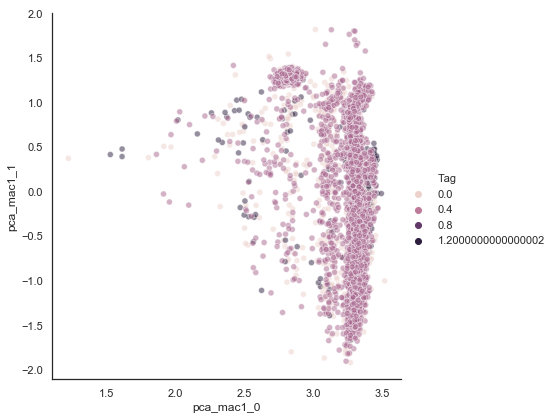

In [156]:
import seaborn as sns
sns.set(style="white")

# Load the example mpg dataset


# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="pca_mac1_0", y="pca_mac1_1", hue="Tag", 
            sizes=(40, 400), alpha=.5,
            height=6, data=ddp)



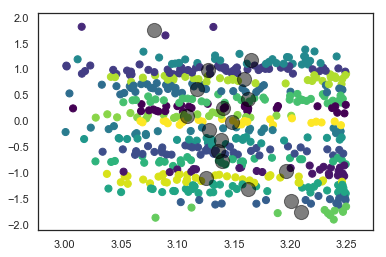

In [130]:
plt.scatter(X['pca_mac1_0'], X['pca_mac1_1'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [131]:
dd['ym'] = y_kmeans

In [133]:
len(dd[dd['ym'] == 9])

28

In [132]:
dd.groupby('ym')['Tag'].agg({'TagMean':"mean"}).reset_index()

,ym,TagMean
0,0,0.383333
1,1,0.340000
2,2,0.333333
3,3,0.313559
4,4,0.325000
5,5,0.406250
6,6,0.357143
7,7,0.272727
8,8,0.265625
9,9,0.464286


In [124]:
dd.groupby('ym')['Tag'].agg({'TagMean':"mean"}).reset_index()

,ym,TagMean
0,0,0.273585
1,1,0.335821
2,2,0.409091
3,3,0.333333
4,4,0.328358
5,5,0.380000
6,6,0.380000
7,7,0.355769
8,8,0.355769
9,9,0.333333


In [107]:
7
dd.groupby('ym')['Tag'].agg({'TagMean':"mean"}).reset_index()

,ym,TagMean
0,0,0.375000
1,1,0.306034
2,2,0.372093
3,3,0.335714
4,4,0.376344
5,5,0.335443
6,6,0.381356


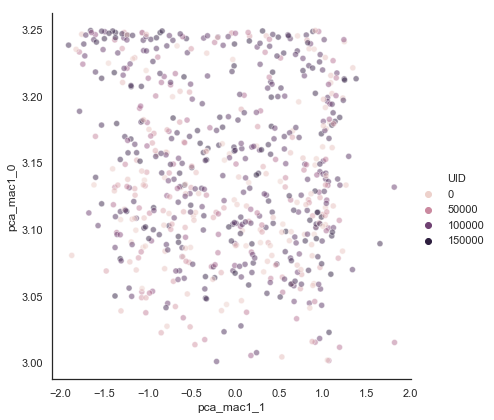

In [90]:
import seaborn as sns
sns.set(style="white")

# Load the example mpg dataset
mpg = sns.load_dataset("mpg")

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="pca_mac1_1", y="pca_mac1_0", hue="UID", alpha=.5, 
            height=6, data=pacdatd)

In [ ]:
#create labeled x and y data
data = pd.DataFrame(index=range(n*len(groups)), columns=['x','y','label'])
for i, group in enumerate(groups.keys()):
    #randomly select n datapoints from a gaussian distrbution
    data.loc[i*n:((i+1)*n)-1,['pca_mac1_0','pca_mac1_1']] = np.random.normal(groups[group], 
                                                           [0.5,0.5], 
                                                           [n,2])
    #add group labels
    data.loc[i*n:((i+1)*n)-1,['UID']] = group

D:\Programfiles2\anaconda\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


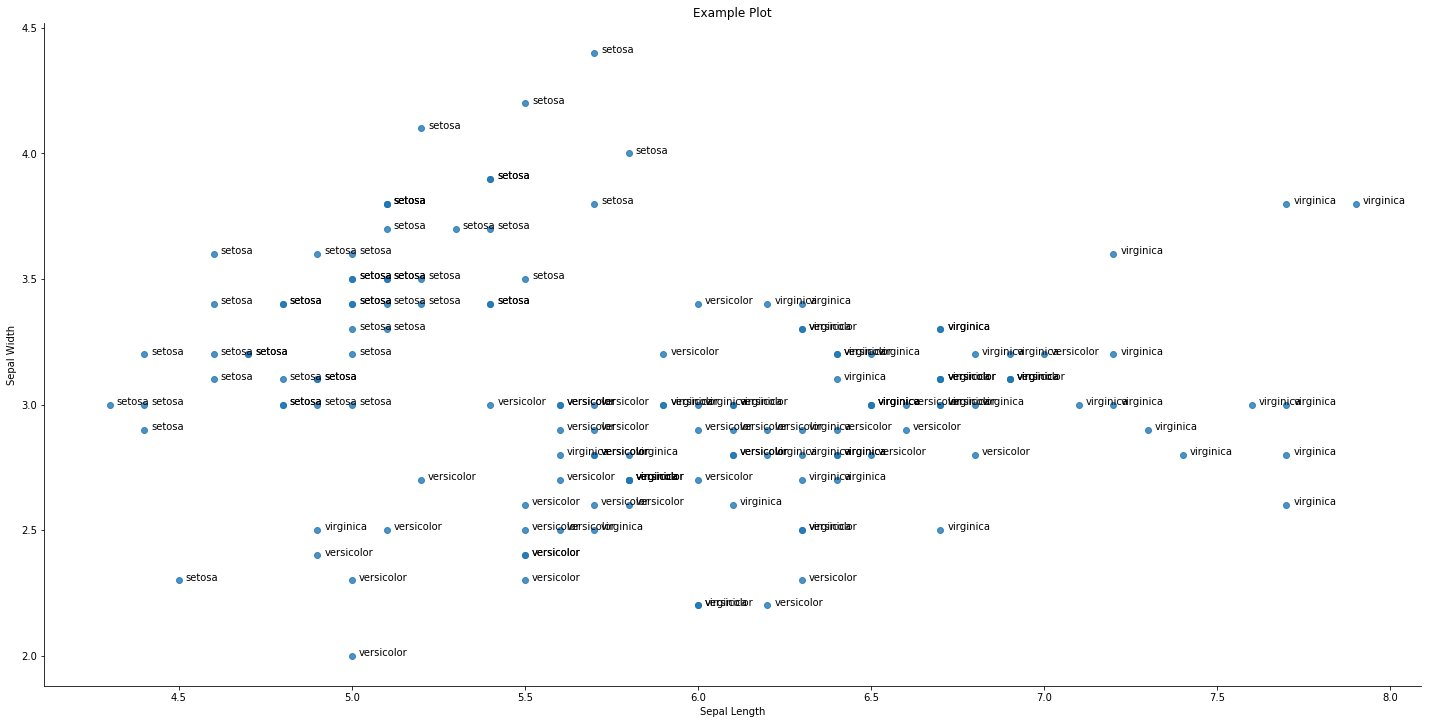

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

df_iris=sns.load_dataset("iris") 

ax = sns.lmplot('sepal_length', # Horizontal axis
           'sepal_width', # Vertical axis
           data=df_iris, # Data source
           fit_reg=False, # Don't fix a regression line
           size = 10,
           aspect =2 ) # size and dimension

plt.title('Example Plot')
# Set x-axis label
plt.xlabel('Sepal Length')
# Set y-axis label
plt.ylabel('Sepal Width')


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df_iris.sepal_length, df_iris.sepal_width, df_iris.species, plt.gca())

In [171]:
scores = ''' 1 youwenbin avgModel.csv 2018-12-10 10:56 1 0.279815 --   
 2  Grand Rookie final1.csv 2018-12-14 09:19 1 0.57***6 0.589542   
 3  Grand Rookie final3.csv 2018-12-14 09:51 2 0.57**4 0.590406   
 4  Grand Rookie weight_blend+rule3.csv 2018-12-14 05:29 3 0.55***3 --   
 5  Grand Rookie final2.csv 2018-12-14 09:31 4 0.54***3 --   
 6  Grand Rookie weight_blend+rule2.csv 2018-12-13 17:21 5 0.53***2 --   
 7  Grand Rookie avg_blend+rule4.csv 2018-12-13 12:22 6 0.53***5 --   
 8  Grand Rookie scale_weight_blend+rule1.csv 2018-12-13 17:05 7 0.52***2 --   
 9  Grand Rookie rank_weight_blend+rule1.csv 2018-12-13 14:08 8 0.52***1 --   
 10  Grand Rookie avg_blend+rule3.csv 2018-12-13 00:34 9 0.49***8 --   
 11  Grand Rookie avg_blend+rule.csv 2018-12-12 02:09 10 0.48***6 --   
 12  Grand Rookie avg_blend_1.csv 2018-12-12 00:08 11 0.43*5 --   
 13  Grand Rookie avg_blend+rule2.csv 2018-12-12 14:22 12 0.39***8 --   
 14  Grand Rookie stacking_2.csv 2018-12-14 05:15 13 0.37***5 --   
 15  Grand Rookie lgb_baseline_12-11-00-11.csv 2018-12-10 10:11 14 0.36***2 --   
 16  Grand Rookie lgb_baseline_12-12-01-24.csv 2018-12-12 01:25 15 0.36***4 --   
 17  Grand Rookie lgb_baseline_12-11-11-21.csv 2018-12-10 21:25 16 0.36***6 --   
 18  Grand Rookie lgb_baseline_12-11-23-29.csv 2018-12-11 23:30 17 0.36***6 --   
 19  Grand Rookie lgb_baseline_12-11-11-46.csv 2018-12-10 21:47 18 0.33***6 --   
 20  Grand Rookie lgb_baseline_12-11-20-24.csv 2018-12-11 20:26 19 0.28***8 --   
 21  Grand Rookie lgb_baseline_12-12-13-42.csv 2018-12-12 13:45 20 0.26***1 --   
 22  Grand Rookie lgb_baseline_12-11-20-59.csv 2018-12-11 21:00 21 0.26***5 --   
 23  Grand Rookie lgb_baseline_12-10-20-46.csv 2018-12-10 06:47 22 0.24***6 --   
 24  进决赛就去见菜嫂 lgb_baseline_12-11-19-56.csv 2018-12-11 19:57 1 0.29***7 --   
 25  进决赛就去见菜嫂 baseline_ 2018-12-10 07:48 2 0.25***2 --   
 26  进决赛就去见菜嫂 baseline_ 2018-12-10 08:22 3 0.25**4 --   
 27  进决赛就去见菜嫂 baseline_ 2018-12-11 20:04 4 0.21***1 --   '''
  

In [172]:
sc = []
scores = scores.split("\n")

In [174]:
scores_1 = [s.split(" ") for s in scores]

In [178]:
scores_1 = [( dt_sc[-8] ,dt_sc[-5])  for dt_sc in scores_1]

In [179]:
scores_1

[('2018-12-10', '0.279815'),
 ('2018-12-14', '0.57***6'),
 ('2018-12-14', '0.57**4'),
 ('2018-12-14', '0.55***3'),
 ('2018-12-14', '0.54***3'),
 ('2018-12-13', '0.53***2'),
 ('2018-12-13', '0.53***5'),
 ('2018-12-13', '0.52***2'),
 ('2018-12-13', '0.52***1'),
 ('2018-12-13', '0.49***8'),
 ('2018-12-12', '0.48***6'),
 ('2018-12-12', '0.43*5'),
 ('2018-12-12', '0.39***8'),
 ('2018-12-14', '0.37***5'),
 ('2018-12-10', '0.36***2'),
 ('2018-12-12', '0.36***4'),
 ('2018-12-10', '0.36***6'),
 ('2018-12-11', '0.36***6'),
 ('2018-12-10', '0.33***6'),
 ('2018-12-11', '0.28***8'),
 ('2018-12-12', '0.26***1'),
 ('2018-12-11', '0.26***5'),
 ('2018-12-10', '0.24***6'),
 ('2018-12-11', '0.29***7'),
 ('2018-12-10', '0.25***2'),
 ('2018-12-10', '0.25**4'),
 ('2018-12-11', '0.21***1')]